# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 200000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (200000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(160178, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

80.089

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(160176, 10)


1    134799
0     25377
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more g

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and"ko-"  is "child of" or of "derived from".) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.
What can I say..

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is the Japanese version of breadcrumb pan bread a Portuguese loan word and quot ko quot is quot child of quot or of quot derived from quot Panko are used for katsudon tonkatsu or cutlets served on rice or in soups The cutlets pounded chicken or pork are coated with these light and crispy crumbs and fried They are not gritty and dense like regular crumbs They are very nice on deep fried shrimps and decorative for a more gourmet touch 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 160176/160176 [01:14<00:00, 2157.79it/s]


In [23]:
preprocessed_reviews[1500]

'japanese version breadcrumb pan bread portuguese loan word ko child derived panko used katsudon tonkatsu cutlets served rice soups cutlets pounded chicken pork coated light crispy crumbs fried not gritty dense like regular crumbs nice deep fried shrimps decorative gourmet touch'

# Obtaining the Required DataFrame (W/O Feature Engineering) :

In [24]:
type(preprocessed_reviews)

list

Basically after all the text preprocessing was carried out we obtained a list, whereas the dataset that we have is 
named 'final'. Initially I had a total of 200K datapoints to work upon which got reduced to approx. 160K datapoints
after the entire deduplication as well as text preprocessing was carried out.

In [25]:
print(final.shape)

(160176, 10)


In [26]:
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138695,150513,0006641040,ASH0DZQQF6AIZ,tessarat,0,0,1,1325721600,A classic,I remembered this book from my childhood and g...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books..."
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...


Basically, again, what we are concerned about is the Preprocessed text whereas in the dataframe named 'final' we only
have the 'Text' as a feature. So first I will add the preprocessed text as a column to this dataframe before proceeding any further.

In [27]:
final['Preprocessed_Reviews'] = preprocessed_reviews

In [28]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Preprocessed_Reviews
138695,150513,0006641040,ASH0DZQQF6AIZ,tessarat,0,0,1,1325721600,A classic,I remembered this book from my childhood and g...,remembered book childhood got kids good rememb...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children books ever written mini vers...
138686,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,1,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...,entertaining rhyming story cleaver catchy illu...
138685,150503,0006641040,A3R5XMPFU8YZ4D,"Her Royal Motherliness ""Nana""",1,1,1,1233964800,so fun to read,This is my grand daughter's and my favorite bo...,grand daughter favorite book read loves rhythm...


Now I have a total of approx. 160K rows in the dataframe called 'final', of which I will consider only 100K rows to
be applied to the Naive Bayes Classifier. Also here you have the Unix Timestamp in the data, which is basically the
time when the review was posted. 

This makes it possible to carry out Time Based Split of the data instead of random splitting of the data into Train,
CV and Test Datasets. For Time Based Split I will take the oldest of the reviews as the Training Data, the 
intermediate reviews as the CV data and the latest reviews as the Test data. 

Now to carry out the Time Based Split on the Unix Timestamp, first the reviews need to be sorted based on the 'Time'
feature.

In [29]:
final_TBS = final.sort_values('Time')

In [30]:
final_TBS.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Preprocessed_Reviews
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apartment infested fruit flies hours tr...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,really good idea final product outstanding use...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...


Now the values have been sorted on the basis of Time and by default the rows (reviews) are sorted in ascending order
of time.

# Obtaining Train, CV and Test Data (W/O FE been carried out) :-

First I will remove all the useless columns from this dataframe of mine. The only columns that we are concerned about 
here are the 'Score' and the 'Preprocessed_reviews'. The remaining columns in the dataframe are of no use to us.

In [31]:
df = final_TBS[['Score','Preprocessed_Reviews']]

In [32]:
df.head()

,Score,Preprocessed_Reviews
138706,1,witty little book makes son laugh loud recite ...
138683,1,remember seeing show aired television years ag...
70688,1,bought apartment infested fruit flies hours tr...
1146,1,really good idea final product outstanding use...
1145,1,received shipment could hardly wait try produc...


In [33]:
cleandf = df[:100000]

Basically we are taking a total of 100K reviews for the model. Since I am carrying out Time Based Splitting into 
Train, CV and Test datasets, I will split them in 70:10:20 ratio respectively. 
        
        So, # of Datapoints in Train data = 70,000 
            # of Datapoints in CV data = 10,000
            # of Datapoints in Test data = 20,000

In [34]:
Tr_df = cleandf[:70000]
CV_df = cleandf[70000:80000]
Te_df = cleandf[80000:100000]

 Validating the Shapes of the Train, CV and Test Datasets to ensure that everything is
working as expected: 

In [35]:
Tr_df.shape

(70000, 2)

In [36]:
CV_df.shape

(10000, 2)

In [37]:
Te_df.shape

(20000, 2)

So yes, everything is fair as expected : 70K datapoints in Training data, 10K datapoints in CV data and 20K datapoints in Test data. Now we are good to proceed further. 

Now we can split the datasets into their X and Y parts.

In [38]:
X_Train1 = Tr_df['Preprocessed_Reviews']
Y_Train1 = Tr_df['Score']

X_CV1 = CV_df['Preprocessed_Reviews']
Y_CV1 = CV_df['Score']

X_Test1 = Te_df['Preprocessed_Reviews']
Y_Test1 = Te_df['Score']

In [39]:
Y_Train1.value_counts()

1    60269
0     9731
Name: Score, dtype: int64

In [40]:
Y_CV1.value_counts()

1    8266
0    1734
Name: Score, dtype: int64

In [41]:
Y_Test1.value_counts()

1    16635
0     3365
Name: Score, dtype: int64

Therefore, as expected this is an imbalanced real world dataset.

# Applying Multinomial Naive Bayes :-

# [5.1] Applying Naive Bayes on BOW (W/O FE) :-

# SET 1: Review text, preprocessed one converted into vectors using (BOW)

In [42]:
count_vect = CountVectorizer()
count_vect.fit(X_Train1) # fit function is being applied only on the Train Data. 

#fit internally stores the parameters that will be used for transforming the data from the text to a numerical
#vector.

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [43]:
X_Train_BOW = count_vect.transform(X_Train1)
X_CV_BOW = count_vect.transform(X_CV1)
X_Test_BOW = count_vect.transform(X_Test1)

In [44]:
print("Shapes before the BOW Vectorization was carried out:")

print(X_Train1.shape, Y_Train1.shape)
print(X_CV1.shape, Y_CV1.shape)
print(X_Test1.shape, Y_Test1.shape)

print("*"*100)

print("Shapes after the BOW Vectorization was carried out:")

print(X_Train_BOW.shape,Y_Train1.shape)
print(X_CV_BOW.shape,Y_CV1.shape)
print(X_Test_BOW.shape,Y_Test1.shape)

Shapes before the BOW Vectorization was carried out:
(70000,) (70000,)
(10000,) (10000,)
(20000,) (20000,)
****************************************************************************************************
Shapes after the BOW Vectorization was carried out:
(70000, 49871) (70000,)
(10000, 49871) (10000,)
(20000, 49871) (20000,)


# Hyperparameter Tuning on the BOW Representation (W/O FE) :- 

Here, I will take the values of alpha in the range from 10^-4 to 10^4 and apply the same on the CV dataset with AUC
as the metric to obtain the best value of alpha. 

In [45]:
alpha_hyperparam=[]
#initializing an empty list

for a in range(-4,5):
    alpha_hyperparam.append(10**a)

#For the range() function if we need to consider the values from -4 to +4 in the exponent, the stop needs to be +5. 

In [46]:
print(alpha_hyperparam)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


In [47]:
#Importing the Required Packages 

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

from tqdm import tqdm
#tqdm is used to print the status bar

In [48]:
Train_BOW_AUC =[]
CV_BOW_AUC=[]

for a in tqdm(alpha_hyperparam):
    naive = MultinomialNB(alpha=a)
    naive.fit(X_Train_BOW,Y_Train1)
    
    Y_Train_pred1 = naive.predict_proba(X_Train_BOW)[:,1]
    Y_CV_pred1 = naive.predict_proba(X_CV_BOW)[:,1]
    
    Train_BOW_AUC.append(roc_auc_score(Y_Train1,Y_Train_pred1))
    CV_BOW_AUC.append(roc_auc_score(Y_CV1,Y_CV_pred1))   

100%|██████████| 9/9 [00:01<00:00,  7.86it/s]


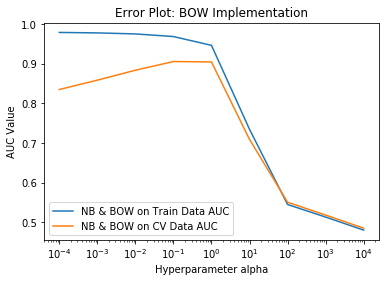

In [49]:
import matplotlib.pyplot as plt

plt.plot(alpha_hyperparam,Train_BOW_AUC, label = "NB & BOW on Train Data AUC")
plt.plot(alpha_hyperparam,CV_BOW_AUC, label = "NB & BOW on CV Data AUC")
plt.xscale('log')

plt.legend()
plt.xlabel('Hyperparameter alpha')
plt.ylabel('AUC Value')
plt.title('Error Plot: BOW Implementation')

plt.grid(False)
plt.show()

From the curves plotted above we choose the Best value of alpha on the basis of AUC as a metric such that :
* The AUC value on the CV Dataset is the maximum. 
* The gap between the Train and CV AUC Curves is low. 

Therefore based on these 2 conditions, with the help of the curves above, I can choose the best value of alpha to be 
equal to :

In [50]:
#Best value of alpha = 10^0 ie 1
best_alpha = 1

#Since the AUC value in this scenario is approx. 0.90.

# Obtaining the Top 10 Important Features:- 

Now basically we can train our Naive Bayes Model on the best value of alpha that we obtained above in Cross
Validation.

In [51]:
naive1 = MultinomialNB(alpha=best_alpha)
naive1.fit(X_Train_BOW,Y_Train1)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [52]:
Y_Train_pred1 = naive1.predict(X_Train_BOW)

In [53]:
print(naive1.classes_)
log_probabilities1 = naive1.feature_log_prob_

print(log_probabilities1)

[0 1]
[[-11.94968681 -13.0482991  -13.0482991  ... -12.35515192 -13.0482991
  -13.0482991 ]
 [-12.10292762 -13.05843907 -12.87611751 ... -14.66787698 -13.9747298
  -13.9747298 ]]


In [54]:
len(log_probabilities1[1])

49871

First I have used the Naive Bayes attribute called "classes_" which basically returns the names of distinct classes
in the dataset. Here in this scenario this is a Binary classification problem and hence we have 2 classes returned:
                                
                                class 0 :- Negative class, 
                            and,class 1 :- Positive class.
                            
The order in which the 2 classes are returned is also important. This is because the nd array obtained by fetaure_log_prob_ (present in the log_probabilities variable) also returns the log probabilities for each word
in this order ie. :-
               
               Row 1 in the matrix :- Log Probabilities of the corresponding word belonging to class "0" {Negative}
               Row 2 in the matrix :- Log Probabilities of the corresponding word belonging to class "1" {Positive}
               
Also, since the model is fit on Train data, the length of each element in the array = No. of unique words in X_Train_BOW ie 49,871 in our case.             

# [5.1.1] Top 10 Important features of Positive Class from BOW (Set 1) :

In [55]:
positive_log_probabilities1 = log_probabilities1[1]

print(positive_log_probabilities1)

[-12.10292762 -13.05843907 -12.87611751 ... -14.66787698 -13.9747298
 -13.9747298 ]


In [56]:
feature_names1 = count_vect.get_feature_names()
type(feature_names1)

list

We have stored the feature names ie. basically each of the words in X_Train_BOW inside a variable called feature_names1 which is a list.

In [57]:
sorted_positiveprob1 = list(np.argsort(positive_log_probabilities1)) 

Now what I am doing is as follows:
    * What argsort() does is it first sorts all the elements in the list and then returns the presorted indices
      of the elements. These presorted indices are important because the feature names will correspond to the
      presorted indices only. 
    * However, argsort() is used because at the same time we also want the features corresponding to the largest 
      10 log probabilities. These largest 10 log probabilities can be obtained by considering the last 10 elements
      of the list (or by the first 10 elements after reversing the list).

In [58]:
#I am reversing the list over here because I want the largest log of probability value to be printed first followed by
#the values in descending order

sorted_positiveprob1.reverse()

In [59]:
print("The Top 10 Most Important Positive Features with BOW Representation are as follows:")
print("="*100)

for i in sorted_positiveprob1[0:10]:
    print(feature_names1[i], "\t", round(positive_log_probabilities1[i],3))

The Top 10 Most Important Positive Features with BOW Representation are as follows:
not 	 -3.756
like 	 -4.586
good 	 -4.707
great 	 -4.764
one 	 -4.899
tea 	 -4.981
taste 	 -4.986
coffee 	 -5.085
flavor 	 -5.099
love 	 -5.13


# [5.1.2] Top 10 Important features of Negative Class from BOW (Set 1) :

In [60]:
negative_log_probabilities1 = log_probabilities1[0]
print(negative_log_probabilities1)

[-11.94968681 -13.0482991  -13.0482991  ... -12.35515192 -13.0482991
 -13.0482991 ]


In [61]:
sorted_negativeprob1 = list(np.argsort(negative_log_probabilities1))

In [62]:
#I am reversing the list over here because I want the largest log of probability value to be printed first followed by
#the values in descending order

sorted_negativeprob1.reverse()

In [63]:
print("The Top 10 Most Important Negative Features with BOW Representation are as follows: ")
print("="*100)

for i in sorted_negativeprob1[0:10]:
    print(feature_names1[i],"\t", round(negative_log_probabilities1[i],3))

The Top 10 Most Important Negative Features with BOW Representation are as follows: 
not 	 -3.405
like 	 -4.525
taste 	 -4.776
would 	 -4.776
product 	 -4.832
one 	 -4.97
good 	 -5.186
coffee 	 -5.242
flavor 	 -5.265
no 	 -5.299


# Testing with the Test Data for BOW Representation (W/O FE) :-

I will use the Training data and the best value of alpha that we obtained from CV that will be used to train the
model before we test the same on the test data.

In [64]:
naive1 = MultinomialNB(alpha=best_alpha)
naive1.fit(X_Train_BOW,Y_Train1)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [65]:
X_Train_BOW.shape

(70000, 49871)

In [66]:
Y_Train1.shape

(70000,)

In [67]:
X_Test_BOW.shape

(20000, 49871)

In [68]:
Y_Test1.shape

(20000,)

In [69]:
from sklearn.metrics import roc_curve,auc

train_fpr2,train_tpr2,thresholds = roc_curve(Y_Train1,naive1.predict_proba(X_Train_BOW)[:,1])
test_fpr2, test_tpr2, thresholds = roc_curve(Y_Test1,naive1.predict_proba(X_Test_BOW)[:,1])

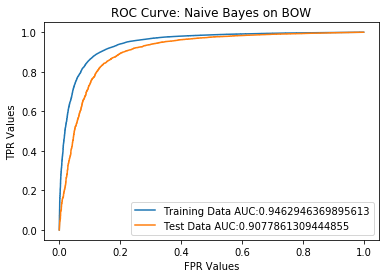

In [70]:
import matplotlib.pyplot as plt

plt.plot(train_fpr2,train_tpr2, label = "Training Data AUC:" + str(auc(train_fpr2,train_tpr2)))
plt.plot(test_fpr2,test_tpr2, label = "Test Data AUC:" + str(auc(test_fpr2,test_tpr2)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: Naive Bayes on BOW')

plt.grid(False)
plt.show()

<b> <font color="black"> User Defined Function to obtain the best value of Threshold with Best Tradeoff between TPR and FPR :- </font> </b>

In [71]:
def matrixpredict(data,thresholds,tpr,fpr):
    matrixpredict.best_tradeoff = tpr*(1-fpr)
    matrixpredict.ideal_threshold = thresholds[matrixpredict.best_tradeoff.argmax()]
    
    predictions = []
    
    for i in data:
        if i>= matrixpredict.ideal_threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

<b> <font color="black"> User Defined Function to plot the Heatmap of The Confusion Matrix for the Training Data: </font> </b>

In [72]:
import seaborn as sns

def plottrainmatrix (train_matrix):
    sns.set_style("whitegrid")
    
    labels = [0,1]
    
    print("-"*20, "Training Confusion Matrix", "-"*20)
    print(" ")
    print("The Training Data Confusion Matrix is as follows:")
    print(" ")
    print("The maximum value of tpr*(1-fpr) :", max(matrixpredict.best_tradeoff))
    print("Threshold for Maximum Value of tpr*(1-fpr) :",round(matrixpredict.ideal_threshold,3))
   
    plt.figure(figsize=(10,7))
    
    
    sns.heatmap(train_matrix,
                annot=True, cmap="YlGnBu",fmt=".0f", xticklabels=labels, yticklabels=labels,
                annot_kws={"size": 15})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

<b> <font color="black"> User Defined Function to plot the HeatMap of The Confusion Matrix for the Test Data: </font> </b>

In [73]:
import seaborn as sns

def plottestmatrix (test_matrix):
    labels = [0,1]
    
    print("-"*20, "Test Data Confusion Matrix", "-"*20)
    print(" ")
    print("The Test Data Confusion Matrix is as follows:")
    print(" ")
    print("The maximum value of tpr*(1-fpr) :", max(matrixpredict.best_tradeoff))
    print("Threshold for Maximum Value of tpr*(1-fpr) :",round(matrixpredict.ideal_threshold,3))
   
    plt.figure(figsize=(10,7))
   
    sns.heatmap(test_matrix,annot=True, cmap="YlGnBu",fmt=".0f", xticklabels=labels, 
                yticklabels=labels,annot_kws={"size": 15})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()     

In [74]:
Y_Test_pred1 = naive1.predict_proba(X_Test_BOW)[:,1]

The Train Data Confusion Matrix looks as follows:-

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.7807711147875495
Threshold for Maximum Value of tpr*(1-fpr) : 0.001


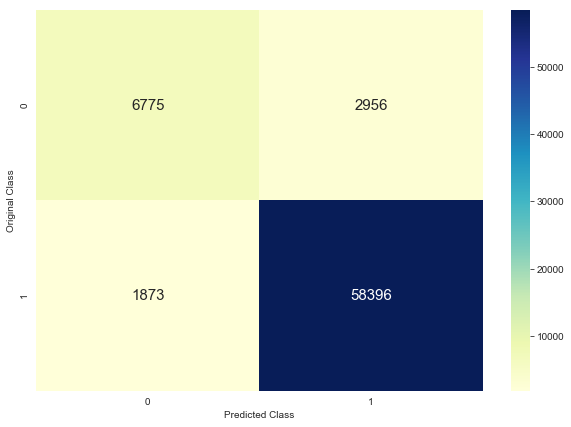

In [75]:
BOW_Train = confusion_matrix(Y_Train1,matrixpredict(Y_Train_pred1,thresholds,train_tpr2,train_fpr2))
plottrainmatrix(BOW_Train)

Accuracy on the Training Data = (58396+6775)/70000 =>  93.10 %.

Similarly the Test Data Confusion Matrix is as follows:-

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.7191701201078483
Threshold for Maximum Value of tpr*(1-fpr) : 0.982


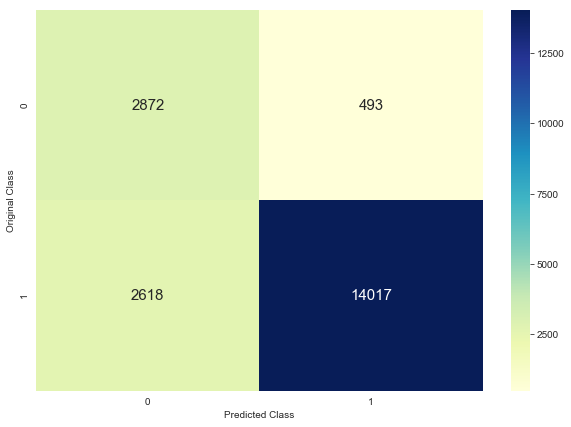

In [76]:
BOW_Test = confusion_matrix(Y_Test1,matrixpredict(Y_Test_pred1,thresholds,test_tpr2,test_fpr2))
plottestmatrix(BOW_Test)

Accuracy on the Test data = 84.44 %

# [5.2] Applying Naive Bayes on TFIDF (W/O FE) :-

# SET 2: Review text, preprocessed one converted into vectors using (TFIDF)

In [77]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_Train1)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [78]:
X_Train_TFIDF = tf_idf_vect.transform(X_Train1)
X_CV_TFIDF = tf_idf_vect.transform(X_CV1)
X_Test_TFIDF = tf_idf_vect.transform(X_Test1)

In [79]:
print("Shapes of the vectors before TFIDF Representation was carried out:")

print(X_Train1.shape,Y_Train1.shape)
print(X_CV1.shape,Y_CV1.shape)
print(X_Test1.shape,Y_Test1.shape)

print("="*100)

print("Shapes of the vectors after TFIDF Representation was carried out:")

print(X_Train_TFIDF.shape,Y_Train1.shape)
print(X_CV_TFIDF.shape,Y_CV1.shape)
print(X_Test_TFIDF.shape,Y_Test1.shape)

Shapes of the vectors before TFIDF Representation was carried out:
(70000,) (70000,)
(10000,) (10000,)
(20000,) (20000,)
Shapes of the vectors after TFIDF Representation was carried out:
(70000, 40652) (70000,)
(10000, 40652) (10000,)
(20000, 40652) (20000,)


# Hyperparameter Tuning on the TFIDF Representation:

In [80]:
print(alpha_hyperparam)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


In [81]:
Train_TFIDF_AUC=[]
CV_TFIDF_AUC=[]

for a in alpha_hyperparam:
    naive = MultinomialNB(alpha=a)
    naive.fit(X_Train_TFIDF,Y_Train1)
    
    Y_Train_pred2 = naive.predict_proba(X_Train_TFIDF)[:,1]
    Y_CV_pred2 = naive.predict_proba(X_CV_TFIDF)[:,1]
    
    Train_TFIDF_AUC.append(roc_auc_score(Y_Train1,Y_Train_pred2))
    CV_TFIDF_AUC.append(roc_auc_score(Y_CV1,Y_CV_pred2))    

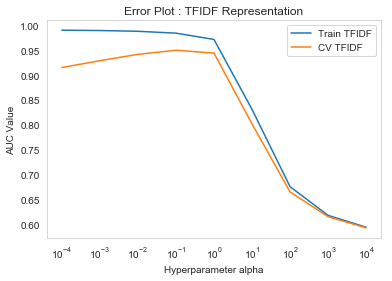

In [82]:
import matplotlib.pyplot as plt

plt.plot(alpha_hyperparam,Train_TFIDF_AUC, label = "Train TFIDF")
plt.plot(alpha_hyperparam,CV_TFIDF_AUC,label="CV TFIDF")
plt.xscale('log')
plt.legend()

plt.xlabel('Hyperparameter alpha')
plt.ylabel('AUC Value')
plt.title('Error Plot : TFIDF Representation')

plt.grid(False)
plt.show()

Again, based on the criteria in choosing the best value of alpha, we need to look for 2 things:
    1. Largest value of AUC score for the CV Plot for a particular value of alpha. 
    2. Smallest gap in the 2 plots of TFIDF and AUC for the chosen value of alpha. 
    
Based on these 2 conditions, the Best Value of alpha in this scenario would be as follows:

In [83]:
best_alpha = 1
#10^0 is the best value of alpha.

# Obtaining the Top 10 Important Features with TFIDF Implementation:- 

Now we can work on the Training dataset basis the best value of alpha obtained after Cross Validation.

In [84]:
naive2 = MultinomialNB(alpha=best_alpha)
naive2.fit(X_Train_TFIDF,Y_Train1)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [85]:
Y_Train_pred2 = naive2.predict(X_Train_TFIDF)

In [86]:
print(naive2.classes_)

log_probabilities2 = naive2.feature_log_prob_
print(log_probabilities2)

[0 1]
[[-11.04935408 -11.1061419  -11.49257509 ... -10.8931964  -11.39692889
  -11.11683862]
 [-11.69459725 -11.8854597  -11.81442195 ... -10.45415607 -11.80994774
  -10.99385424]]


In [87]:
len(log_probabilities2[0])
len(log_probabilities2[1])

40652

First I have used the Naive Bayes attribute called "classes_" which basically returns the names of distinct classes
in the dataset. Here in this scenario this is a Binary classification problem and hence we have 2 classes returned:
                                
                                class 0 :- Negative class, 
                            and,class 1 :- Positive class.
                            
The order in which the 2 classes are returned is also important. This is because the nd array obtained by fetaure_log_prob_ (present in the log_probabilities variable) also returns the log probabilities for each word
in this order ie. :-
               
               Row 1 in the matrix :- Log Probabilities of the corresponding word belonging to class "0" {Negative}
               Row 2 in the matrix :- Log Probabilities of the corresponding word belonging to class "1" {Positive}
               
Also, since the model is fit on Train data, the length of each element in the array = No. of unique words in X_Train_TFIDF ie 40,652 in our case. 

# Top 10 Important Features of the Positive Class for TFIDF (Set 2) :

In [88]:
positive_log_probabilities2 = log_probabilities2[1]

print(positive_log_probabilities2)

[-11.69459725 -11.8854597  -11.81442195 ... -10.45415607 -11.80994774
 -10.99385424]


In [89]:
feature_names2 = count_vect.get_feature_names()
type(feature_names2)

list

In [90]:
sorted_positiveprob2 = list(np.argsort(positive_log_probabilities2)) 

In [91]:
#I am reversing the list over here because I want the largest log of probability value to be printed first followed by
#the values in descending order

sorted_positiveprob2.reverse()

In [92]:
print("The Top 10 Most Important Positive Features with TFIDF Representation are as follows:")
print("="*100)

for i in sorted_positiveprob2[0:10]:
    print(feature_names2[i], "\t", round(positive_log_probabilities2[i],3))

The Top 10 Most Important Positive Features with TFIDF Representation are as follows:
kelly 	 -5.419
faithfulness 	 -5.777
event 	 -5.843
grooms 	 -5.898
reactive 	 -5.9
capilary 	 -5.988
highlands 	 -6.03
likelihood 	 -6.123
quanities 	 -6.132
monitored 	 -6.134


# Top 10 Important Features of the Negative Class for TFIDF (Set 2) :

In [93]:
negative_log_probabilities2  = log_probabilities2[0]

print(negative_log_probabilities2)

[-11.04935408 -11.1061419  -11.49257509 ... -10.8931964  -11.39692889
 -11.11683862]


In [94]:
sorted_negativeprob2 = list(np.argsort(negative_log_probabilities2))

In [95]:
#I am reversing the list over here because I want the largest log of probability value to be printed first followed by
#the values in descending order

sorted_negativeprob2.reverse()

In [233]:
print("The Top 10 Most Important Negative Features with TFIDF Representation are as follows:")
print("="*100)

for i in sorted_negativeprob2[0:10]:
    print(feature_names2[i], "\t", round(negative_log_probabilities2[i],3))

The Top 10 Most Important Negative Features with TFIDF Representation are as follows:
kelly 	 -5.27
grooms 	 -6.078
quanities 	 -6.174
monitored 	 -6.195
smacking 	 -6.198
capilary 	 -6.435
likelihood 	 -6.473
discredit 	 -6.618
jujubee 	 -6.64
event 	 -6.68


# Testing with the Test Data for TFIDF Representation (W/O FE) :-

I will use the Training data and the best value of alpha that we obtained from CV that will be used to train the
model before we test the same on the test data.

In [97]:
naive2 = MultinomialNB(alpha=best_alpha)
naive2.fit(X_Train_TFIDF,Y_Train1)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [98]:
X_Train_TFIDF.shape

(70000, 40652)

In [99]:
Y_Train1.shape

(70000,)

In [100]:
X_Test_TFIDF.shape

(20000, 40652)

In [101]:
Y_Test1.shape

(20000,)

In [102]:
from sklearn.metrics import roc_curve, auc

train_fpr3,train_tpr3,thresholds = roc_curve(Y_Train1,naive2.predict_proba(X_Train_TFIDF)[:,1])
test_fpr3,test_tpr3,thresholds = roc_curve(Y_Test1,naive2.predict_proba(X_Test_TFIDF)[:,1])

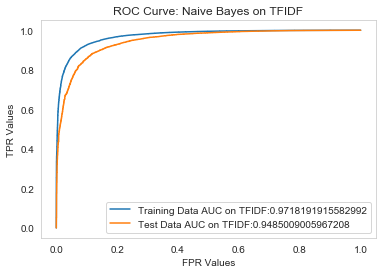

In [103]:
import matplotlib.pyplot as plt

plt.plot(train_fpr3,train_tpr3, label = "Training Data AUC on TFIDF:" + str(auc(train_fpr3,train_tpr3)))
plt.plot(test_fpr3,test_tpr3, label="Test Data AUC on TFIDF:" + str(auc(test_fpr3,test_tpr3)))

plt.legend()

plt.xlabel("FPR Values")
plt.ylabel("TPR Values")
plt.title('ROC Curve: Naive Bayes on TFIDF')

plt.grid(False)
plt.show()

<b> <font color="black"> Plotting the Confusion Matrices for the TFIDF Train Data & Test Data for the Ideal Value
of the Threshold:- </font> </b>

In [104]:
Y_Test_pred2 = naive2.predict_proba(X_Test_TFIDF)[:,1]

The Training Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottrainmatrix() that were defined previously:

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.8364827017727098
Threshold for Maximum Value of tpr*(1-fpr) : 0.822


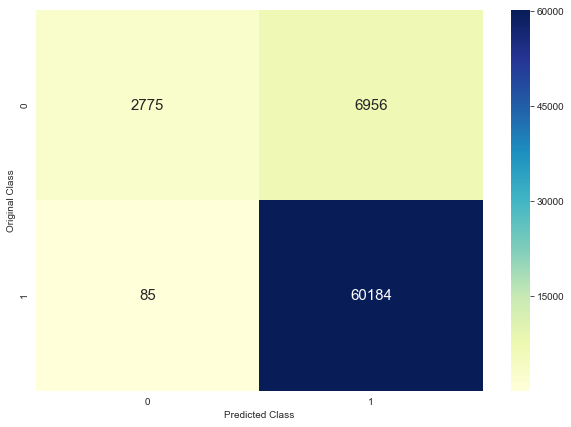

In [105]:
TFIDF_Train = confusion_matrix(Y_Train1,matrixpredict(Y_Train_pred2,thresholds,train_tpr3,train_fpr3))
plottrainmatrix(TFIDF_Train)

Accuracy on the Train Data :- (60184+2775)/70000 => 89.94 %

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottrainmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.7775642666087855
Threshold for Maximum Value of tpr*(1-fpr) : 0.906


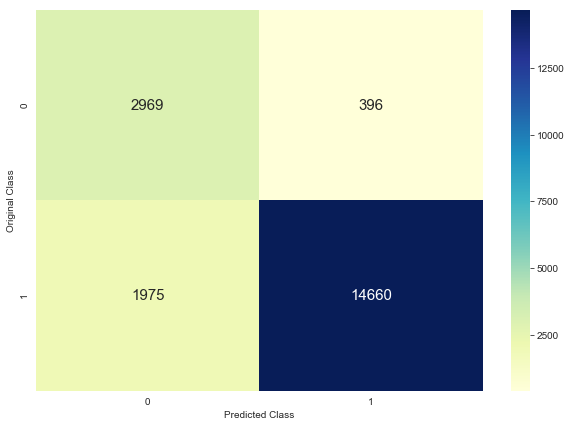

In [106]:
TFIDF_Test = confusion_matrix(Y_Test1,matrixpredict(Y_Test_pred2,thresholds,test_tpr3,test_fpr3))
plottestmatrix(TFIDF_Test)

Accuracy on the Test Data = (14660+2969)/20000 => 88.14 %

<h2><font color='red'>[**] Preprocessing Review Summary</font></h2>

In [107]:
# printing some random reviews
summary_0 = final_TBS['Summary'].values[0]
print(summary_0)
print("="*50)

summary_1000 = final_TBS['Summary'].values[1000]
print(summary_1000)
print("="*50)

summary_1700 = final_TBS['Summary'].values[1700]
print(summary_1700)
print("="*50)

summary_4900 = final_TBS['Summary'].values[4900]
print(summary_4900)
print("="*50)

EVERY book is educational
Somebody better check their specifications
Treat yourself with a great breakfast.
Great Gluten-Free Bread


In [108]:
import warnings
warnings.filterwarnings('ignore')

preprocessed_summary = []

for title in final_TBS['Summary'].values:
    title = re.sub(r"http\S+", "", title)
    title = BeautifulSoup(title, 'lxml').get_text()
    title = decontracted(title)
    title = re.sub("\S*\d\S*", "", title).strip()
    title = re.sub('[^A-Za-z]+', ' ', title)
  
    title = ' '.join(e.lower() for e in title.split() if e.lower() not in stopwords)
    preprocessed_summary.append(title.strip())

In [109]:
preprocessed_summary[1700]

'treat great breakfast'

# Feature Engineering to Increase the Model Performance:

We obtained a dataframe called "final" which had all the columns, out of which we considered only a single column of
"Preprocessed_Reviews" in our final DataFrame, whereas we can try with additional features as our Xis to try and 
improve the model even further.

In [110]:
final_TBS.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Preprocessed_Reviews
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apartment infested fruit flies hours tr...


Adding the Preprocessed Summary as another column to this dataframe:

In [111]:
final_TBS['Preprocessed_Summary'] = preprocessed_summary

In [112]:
Review_Length =[]
for i in final_TBS['Preprocessed_Reviews']:
    Review_Length.append(len(i))

Here, basically I am calculating the length of the 'Preprocessed_Reviews', which is : The number of characters in 
the review after the entire text preprocessing has been carried out.

Now I am adding this particular calculated feature as another column :'Review_Length' in my dataset.

In [113]:
final_TBS['Review_Length'] = Review_Length

In [114]:
final_TBS.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Preprocessed_Reviews,Preprocessed_Summary,Review_Length
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational,222
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...,whole series great way spend time child,222
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apartment infested fruit flies hours tr...,sure death flies,207


# Obtaining the Required Train,CV and Test Datasets (With FE) :- 

First I will remove all the useless columns from this dataframe of mine. Now I will try Feature Engineering: The only
columns that we are concerned about now are the 'Score','Preprocessed_Reviews','Review_Length' & 'Preprocessed_Summary'. The remaining columns in the dataframe are of no use to us.

In [115]:
df2 = final_TBS[['Preprocessed_Summary','Preprocessed_Reviews','Review_Length','Score']]

In [116]:
df2.head()

,Preprocessed_Summary,Preprocessed_Reviews,Review_Length,Score
138706,every book educational,witty little book makes son laugh loud recite ...,222,1
138683,whole series great way spend time child,remember seeing show aired television years ag...,222,1
70688,sure death flies,bought apartment infested fruit flies hours tr...,207,1
1146,great product,really good idea final product outstanding use...,109,1
1145,wow make islickers,received shipment could hardly wait try produc...,277,1


In [117]:
cleandf2 = df2[:100000]

Again, just as in the previous case, I am taking a total of 100K reviews. Again the splitting of the data that I will
carry out will be in the 70:10:20 ratio.

In [118]:
Tr_df2 = cleandf2[:70000]
CV_df2 = cleandf2[70000:80000]
Te_df2 = cleandf2[80000:100000]

In [119]:
Tr_df2.shape

(70000, 4)

In [120]:
CV_df2.shape

(10000, 4)

In [121]:
Te_df2.shape

(20000, 4)

In [122]:
X_Train2 = Tr_df2[['Preprocessed_Summary','Preprocessed_Reviews','Review_Length']]
Y_Train2 = Tr_df2['Score']

X_CV2 = CV_df2[['Preprocessed_Summary','Preprocessed_Reviews','Review_Length']]
Y_CV2 = CV_df2['Score']

X_Test2 = Te_df2[['Preprocessed_Summary','Preprocessed_Reviews','Review_Length']]
Y_Test2 = Te_df2['Score']

In [123]:
type(X_Train2)
type(X_CV2)
type(X_Test2)

pandas.core.frame.DataFrame

Basically, previously when we considered only a single column in our X_Train (Preprocessed_Reviews) we obtained a 
Series whereas in this case we obtain a DataFrame because we are considering multiple columns in our X_Train,X_CV 
and X_Test.

# Applying Multinomial Naive Bayes on BOW (With FE) :-

Previously, we had only 1 feature : Preprocessed_Reviews to be concerned about. However in this scenario we have a
total of 3 features : Preprocessed_Reviews,Preprocessed_Summary as well as the Review_Length to be concerned about.

So, what I will do is as follows:

* We should only fit() on the training data {to understand the vocabulary of the Training Dataset}, however we carry
  out the transformation on all datasets to convert the text data into numeric vectors. 
* Hence, first I will fit and transform the 'Preprocessed_Reviews' feature in my Text dataset and store the same
  in a variable called 'X_Train_Reviews': This has 70K datapoints and 49871 features.
* Next I will fit and transform the 'Preprocessed_Summary' feature from my Text Dataset and store the same in a   variable called 'X_Train_Summary' : This has 70k datapoints and 13358 features. 

In [124]:
count_vect2 = CountVectorizer()
X_Train_Reviews = count_vect2.fit_transform(X_Train2['Preprocessed_Reviews'])

In [125]:
X_Train_Reviews.shape

(70000, 49871)

Also I am performing 2 Vcetorizations separately for the 2 features : 'Preprocessed_Reviews' and 'Preprocessed_Summary', because we want the transformations for the CV and Test Datasets to be carried out separately.

In [126]:
count_vect3 = CountVectorizer()
X_Train_Summary = count_vect3.fit_transform(X_Train2['Preprocessed_Summary'])

In [127]:
X_Train_Summary.shape

(70000, 13358)

In [128]:
type(X_Train_Reviews)

scipy.sparse.csr.csr_matrix

In [129]:
type(X_Train_Summary)

scipy.sparse.csr.csr_matrix

I have looked at the types of both of these variables that I have obtained : Both of them are sparse matrices and
hence they can be easily horizontally stacked using hstack in scipy.sparse, that I have imported below:

In [130]:
from scipy.sparse import hstack

temp_train = hstack([X_Train_Reviews,X_Train_Summary])

In [131]:
temp_train.shape

(70000, 63229)

In [132]:
type(temp_train)

scipy.sparse.coo.coo_matrix

As expected, temp_train has a total of 63229 features : 49871 features from Preprocessed_Reviews as a feature and 
13358 features from Preprocessed_Summary. Now I also want to add Review_Length from X_Train2 into the BOW representation of the dataset. 

We know that Review_Length is a single column and hence it is a pandas series type, which first needs to be converted
into a sparse matrix in order to be again stacked on top of temp_train.

In [133]:
import scipy as sp

A = X_Train2['Review_Length'].as_matrix()
B = sp.sparse.csr_matrix(A)

#Source : https://stackoverflow.com/questions/20459536/convert-pandas-dataframe-to-sparse-numpy-matrix-directly

Now the variable B is the Review_Length converted into a sparse matrix, which can now be horizontally stacked. B 
obtained is a row vector which needs to be transposed in order to be stacked horizontally.

In [134]:
X_Train_BOW2 = hstack([temp_train,B.T])

In [135]:
X_Train_BOW2.shape

(70000, 63230)

Therefore, as expected, X_Train_BOW2 is a sparse matrix obtained that we needed which has 70K datapoints (as required) in the Training Data and a total of 63230 features. 

Now we can carry out the same approach for CV and Test datasets as well:

<b> <font color="black"> Carrying out the same approach for CV Dataset:- </font> </b>

In [136]:
X_CV_Reviews = count_vect2.transform(X_CV2['Preprocessed_Reviews'])

In [137]:
X_CV_Reviews.shape

(10000, 49871)

In [138]:
X_CV_Summary = count_vect3.transform(X_CV2['Preprocessed_Summary'])

In [139]:
X_CV_Summary.shape

(10000, 13358)

In [140]:
type(X_CV_Reviews)
type(X_CV_Summary)

scipy.sparse.csr.csr_matrix

In [141]:
cv_temp = hstack([X_CV_Reviews,X_CV_Summary])

In [142]:
cv_temp.shape

(10000, 63229)

In [143]:
import scipy as sp

C = X_CV2['Review_Length'].as_matrix()
D = sp.sparse.csr_matrix(C)

In [144]:
X_CV_BOW2 = hstack([cv_temp,D.T])

In [145]:
X_CV_BOW2.shape

(10000, 63230)

<b> <font color="black"> Carrying out the same approach for Test Dataset:- </font> </b>

In [146]:
X_Test_Reviews = count_vect2.transform(X_Test2['Preprocessed_Reviews'])

In [147]:
X_Test_Reviews.shape

(20000, 49871)

In [148]:
X_Test_Summary = count_vect3.transform(X_Test2['Preprocessed_Summary'])

In [149]:
X_Test_Summary.shape

(20000, 13358)

In [150]:
type(X_Test_Reviews)
type(X_Test_Summary)

scipy.sparse.csr.csr_matrix

In [151]:
test_temp = hstack([X_Test_Reviews,X_Test_Summary])

In [152]:
test_temp.shape

(20000, 63229)

In [153]:
import scipy as sp

E = X_Test2['Review_Length'].as_matrix()
F = sp.sparse.csr_matrix(E)

In [154]:
X_Test_BOW2 = hstack([test_temp,F.T])

In [155]:
X_Test_BOW2.shape

(20000, 63230)

<b> <font color="black"> Overall Summary:- </font> </b>

In [156]:
print("The final dimensionalities across all datasets after BOW Representation (With FE):")

print(X_Train_BOW2.shape,Y_Train1.shape)
print(X_CV_BOW2.shape,Y_CV1.shape)
print(X_Test_BOW2.shape,Y_Test1.shape)

The final dimensionalities across all datasets after BOW Representation (With FE):
(70000, 63230) (70000,)
(10000, 63230) (10000,)
(20000, 63230) (20000,)


# Hyperparameter Tuning on the BOW Representation (With FE) :-

In [157]:
print(alpha_hyperparam)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


In [158]:
Train_BOW2_AUC =[]
CV_BOW2_AUC=[]

for a in alpha_hyperparam:
    naive = MultinomialNB(alpha=a)
    naive.fit(X_Train_BOW2,Y_Train1)
    
    Y_Train_pred3 = naive.predict_proba(X_Train_BOW2)[:,1]
    Y_CV_pred3 = naive.predict_proba(X_CV_BOW2)[:,1]
    
    Train_BOW2_AUC.append(roc_auc_score(Y_Train1,Y_Train_pred3))
    CV_BOW2_AUC.append(roc_auc_score(Y_CV1,Y_CV_pred3))     

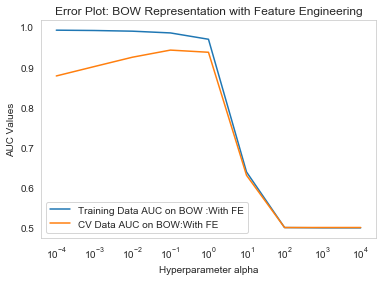

In [159]:
import matplotlib.pyplot as plt

plt.plot(alpha_hyperparam,Train_BOW2_AUC, label="Training Data AUC on BOW :With FE")
plt.plot(alpha_hyperparam,CV_BOW2_AUC, label="CV Data AUC on BOW:With FE")
plt.legend()

plt.xscale('log')

plt.xlabel('Hyperparameter alpha')
plt.ylabel('AUC Values')
plt.title('Error Plot: BOW Representation with Feature Engineering')

plt.grid(False)
plt.show()

Again, on the parameter basis which we choose the best value of alpha :

In [160]:
best_alpha= 1

# Testing with the Test Data for BOW Implementation (With FE) :

In [161]:
naive3 = MultinomialNB(alpha=best_alpha)
naive3.fit(X_Train_BOW2,Y_Train1)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [162]:
X_Train_BOW2.shape

(70000, 63230)

In [163]:
Y_Train1.shape

(70000,)

In [164]:
X_Test_BOW2.shape

(20000, 63230)

In [165]:
Y_Test1.shape

(20000,)

In [166]:
from sklearn.metrics import roc_curve,auc

train_fpr4,train_tpr4,thresholds = roc_curve(Y_Train1,naive3.predict_proba(X_Train_BOW2)[:,1])
test_fpr4,test_tpr4,thresholds = roc_curve(Y_Test1,naive3.predict_proba(X_Test_BOW2)[:,1])

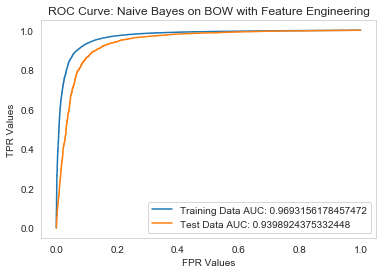

In [167]:
import matplotlib.pyplot as plt

plt.plot(train_fpr4,train_tpr4, label = "Training Data AUC: " + str(auc(train_fpr4,train_tpr4)))
plt.plot(test_fpr4,test_tpr4, label = "Test Data AUC: " + str(auc(test_fpr4,test_tpr4)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: Naive Bayes on BOW with Feature Engineering')

plt.grid(False)
plt.show()

<b> <font color="black"> Plotting the Confusion Matrices for the BOW Test Data (with FE) for the Ideal Value of the Threshold:- </font> </b>

In [168]:
#To plot the confusion matrix
Y_Test_pred3 = naive3.predict_proba(X_Test_BOW2)[:,1]

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.784617977723797
Threshold for Maximum Value of tpr*(1-fpr) : 0.987


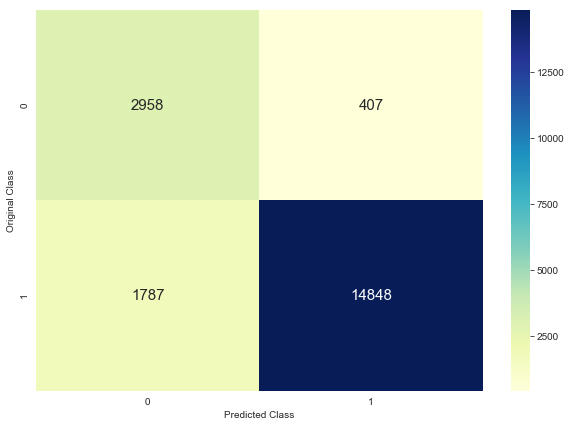

In [169]:
BOW2_Test = confusion_matrix(Y_Test1,matrixpredict(Y_Test_pred3,thresholds,test_tpr4,test_fpr4))
plottestmatrix(BOW2_Test)

Accuracy on the Test Data = (14848+2958)/20000 => 89.03 %

# Applying Multinomial Naive Bayes on TFIDF (With FE) :-

<b> <font color="black"> Carrying out the same approach as the one followed above for Train Dataset with TFIDF
Vectorization:- </font> </b>

In [170]:
tf_idf_vect2 = TfidfVectorizer(ngram_range=(1,2), min_df=10)
X_Train_TFIDF_Reviews = tf_idf_vect2.fit_transform(X_Train2['Preprocessed_Reviews'])

In [171]:
X_Train_TFIDF_Reviews.shape

(70000, 40652)

In [172]:
tf_idf_vect3 = TfidfVectorizer(ngram_range=(1,2), min_df=10)
X_Train_TFIDF_Summary = tf_idf_vect3.fit_transform(X_Train2['Preprocessed_Summary'])

In [173]:
X_Train_TFIDF_Summary.shape

(70000, 3541)

In [174]:
type(X_Train_TFIDF_Reviews)
type(X_Train_TFIDF_Summary)

scipy.sparse.csr.csr_matrix

In [175]:
from scipy.sparse import hstack

temp_train_tfidf = hstack([X_Train_TFIDF_Reviews,X_Train_TFIDF_Summary])

In [176]:
temp_train_tfidf.shape

(70000, 44193)

In [177]:
import scipy as sp

G = X_Train2['Review_Length'].as_matrix()
H = sp.sparse.csr_matrix(G)

#Source : https://stackoverflow.com/questions/20459536/convert-pandas-dataframe-to-sparse-numpy-matrix-directly

In [178]:
X_Train_TFIDF2 = hstack([temp_train_tfidf,H.T])

In [179]:
X_Train_TFIDF2.shape

(70000, 44194)

<b> <font color="black"> Applying the same for CV Dataset:- </font> </b>

In [180]:
X_CV_TFIDF_Reviews = tf_idf_vect2.transform(X_CV2['Preprocessed_Reviews'])

In [181]:
X_CV_TFIDF_Reviews.shape

(10000, 40652)

In [182]:
X_CV_TFIDF_Summary = tf_idf_vect3.transform(X_CV2['Preprocessed_Summary'])

In [183]:
X_CV_TFIDF_Summary.shape

(10000, 3541)

In [184]:
type(X_CV_TFIDF_Reviews)
type(X_CV_TFIDF_Summary)

scipy.sparse.csr.csr_matrix

In [185]:
CV_TFIDF_Temp = hstack([X_CV_TFIDF_Reviews,X_CV_TFIDF_Summary])

In [186]:
CV_TFIDF_Temp.shape

(10000, 44193)

In [187]:
type(CV_TFIDF_Temp)

scipy.sparse.coo.coo_matrix

In [188]:
import scipy as sp
I = X_CV2['Review_Length'].as_matrix()
J = sp.sparse.csr_matrix(I)

In [189]:
X_CV_TFIDF2 = hstack([CV_TFIDF_Temp,J.T])

In [190]:
X_CV_TFIDF2.shape

(10000, 44194)

<b> <font color="black"> Applying the same for Test Dataset:- </font> </b>

In [191]:
X_Test_TFIDF_Reviews = tf_idf_vect2.transform(X_Test2['Preprocessed_Reviews'])

In [192]:
X_Test_TFIDF_Reviews.shape

(20000, 40652)

In [193]:
X_Test_TFIDF_Summary = tf_idf_vect3.transform(X_Test2['Preprocessed_Summary'])

In [194]:
X_Test_TFIDF_Summary.shape

(20000, 3541)

In [195]:
type(X_Test_TFIDF_Reviews)
type(X_Test_TFIDF_Summary)

scipy.sparse.csr.csr_matrix

In [196]:
Test_TFIDF_Temp = hstack([X_Test_TFIDF_Reviews,X_Test_TFIDF_Summary])

In [197]:
Test_TFIDF_Temp.shape

(20000, 44193)

In [198]:
type(Test_TFIDF_Temp)

scipy.sparse.coo.coo_matrix

In [199]:
import scipy as sp
K = X_Test2['Review_Length'].as_matrix()
L = sp.sparse.csr_matrix(K)

In [200]:
X_Test_TFIDF2 = hstack([Test_TFIDF_Temp,L.T])

In [201]:
X_Test_TFIDF2.shape

(20000, 44194)

<b> <font color="black"> Overall Summary:- </font> </b>

In [202]:
print("The final dimensionalities across all datasets after TFIDF Representation (With FE):")

print(X_Train_TFIDF2.shape,Y_Train1.shape)
print(X_CV_TFIDF2.shape,Y_CV1.shape)
print(X_Test_TFIDF2.shape,Y_Test1.shape)

The final dimensionalities across all datasets after TFIDF Representation (With FE):
(70000, 44194) (70000,)
(10000, 44194) (10000,)
(20000, 44194) (20000,)


# Hyperparameter Tuning on the TFIDF Representation (With FE) :-

In [203]:
print(alpha_hyperparam)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


In [204]:
Train_TFIDF2_AUC=[]
CV_TFIDF2_AUC=[]

for a in alpha_hyperparam:
    naive = MultinomialNB(alpha=a)
    naive.fit(X_Train_TFIDF2,Y_Train1)
    
    Y_Train_pred4 = naive.predict_proba(X_Train_TFIDF2)[:,1]
    Y_CV_pred4 = naive.predict_proba(X_CV_TFIDF2)[:,1]
    
    Train_TFIDF2_AUC.append(roc_auc_score(Y_Train1,Y_Train_pred4))
    CV_TFIDF2_AUC.append(roc_auc_score(Y_CV1,Y_CV_pred4))  

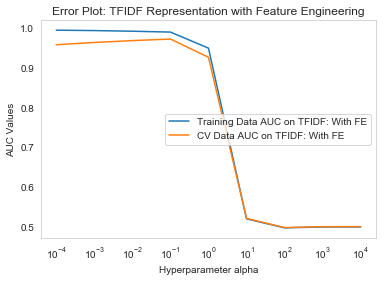

In [205]:
import matplotlib.pyplot as plt

plt.plot(alpha_hyperparam,Train_TFIDF2_AUC, label="Training Data AUC on TFIDF: With FE")
plt.plot(alpha_hyperparam,CV_TFIDF2_AUC, label="CV Data AUC on TFIDF: With FE")
plt.legend()

plt.xscale('log')

plt.xlabel('Hyperparameter alpha')
plt.ylabel('AUC Values')
plt.title('Error Plot: TFIDF Representation with Feature Engineering')

plt.grid(False)
plt.show()

Again, based on the criteria on choosing the Best value of alpha based on the curve above:

In [206]:
Best_alpha = 1
#10^0 = 1

# Testing with the Test Data for TFIDF Implementation (With FE) :-

In [207]:
naive4 = MultinomialNB(alpha=best_alpha)
naive4.fit(X_Train_TFIDF2,Y_Train1)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [208]:
X_Train_TFIDF2.shape

(70000, 44194)

In [209]:
Y_Train1.shape

(70000,)

In [210]:
X_Test_TFIDF2.shape

(20000, 44194)

In [211]:
Y_Test1.shape

(20000,)

In [212]:
from sklearn.metrics import roc_curve,auc

train_fpr5,train_tpr5,thresholds = roc_curve(Y_Train1,naive4.predict_proba(X_Train_TFIDF2)[:,1])
test_fpr5,test_tpr5,thresholds = roc_curve(Y_Test1,naive4.predict_proba(X_Test_TFIDF2)[:,1])

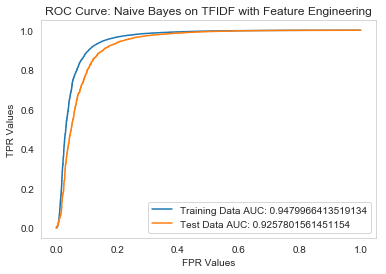

In [213]:
import matplotlib.pyplot as plt

plt.plot(train_fpr5,train_tpr5, label = "Training Data AUC: " + str(auc(train_fpr5,train_tpr5)))
plt.plot(test_fpr5,test_tpr5, label = "Test Data AUC: " + str(auc(test_fpr5,test_tpr5)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: Naive Bayes on TFIDF with Feature Engineering')

plt.grid(False)
plt.show()

<b> <font color="black"> Plotting the Confusion Matrices for the TFIDF Test Data (with FE) for the Ideal Value of the Threshold:- </font> </b>

In [214]:
#To plot the confusion matrix
Y_Test_pred4 = naive4.predict_proba(X_Test_TFIDF2)[:,1]

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.7632204963576412
Threshold for Maximum Value of tpr*(1-fpr) : 0.924


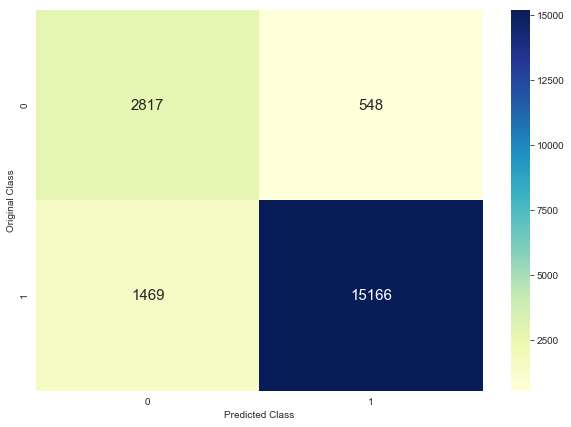

In [215]:
TFIDF2_Test = confusion_matrix(Y_Test1,matrixpredict(Y_Test_pred4,thresholds,test_tpr5,test_fpr5))
plottestmatrix(TFIDF2_Test)

Accuracy on the Test Data = (15166+2817)/20000 => 89.91 %

# [6] Conclusions

In [228]:
from prettytable import PrettyTable

In [229]:
x=PrettyTable()
x.field_names=["S No.","Top 10 Positive Words","Log-Probability(+ve)","Top 10 Negative Words","Log-Probability(-ve)"]

In [230]:
print("Top 10 Positive and Negative Words with BOW Representation:")
print(" "*100)

x.add_row(["1","not","-3.756","not","-3.405"])
x.add_row(["2","like","-4.586","like","-4.525"])
x.add_row(["3","good","-4.707","taste","-4.776"])
x.add_row(["4","great","-4.764","would","-4.776"])
x.add_row(["5","one","-4.899","product","-4.832"])
x.add_row(["6","tea","-4.981","one","-4.97"])
x.add_row(["7","taste","-4.986","good","-5.186"])
x.add_row(["8","coffee","-5.085","coffee","-5.242"])
x.add_row(["9","flavor","-5.099","flavor","-5.265"])
x.add_row(["10","love","-5.13","no","-5.299"])

print(x)

Top 10 Positive and Negative Words with BOW Representation:
                                                                                                    
+-------+-----------------------+----------------------+-----------------------+----------------------+
| S No. | Top 10 Positive Words | Log-Probability(+ve) | Top 10 Negative Words | Log-Probability(-ve) |
+-------+-----------------------+----------------------+-----------------------+----------------------+
|   1   |          not          |        -3.756        |          not          |        -3.405        |
|   2   |          like         |        -4.586        |          like         |        -4.525        |
|   3   |          good         |        -4.707        |         taste         |        -4.776        |
|   4   |         great         |        -4.764        |         would         |        -4.776        |
|   5   |          one          |        -4.899        |        product        |        -4.832        |
|   6  

In [231]:
y=PrettyTable()
y.field_names=["S No.","Top 10 Positive Words","Log-Probability(+ve)","Top 10 Negative Words","Log-Probability(-ve)"]

In [234]:
print("Top 10 Positive and Negative Words with TFIDF Representation:")
print(" "*100)

y.add_row(["1","kelly","-5.419","kelly","-5.27"])
y.add_row(["2","faithfulness","-5.777","grooms","-6.078"])
y.add_row(["3","event","-5.843","quanities","-6.174"])
y.add_row(["4","grooms","-5.898","monitored","-6.195"])
y.add_row(["5","reactive","-5.9","smacking","-6.198"])
y.add_row(["6","capilary","-5.988","capilary","-6.435"])
y.add_row(["7","highlands","-6.03","likelihood","-6.473"])
y.add_row(["8","likelihood","-6.123","discredit","-6.618"])
y.add_row(["9","quanities","-6.132","jujubee","-6.64"])
y.add_row(["10","monitored","-6.134","event","-6.68"])

print(y)

Top 10 Positive and Negative Words with TFIDF Representation:
                                                                                                    
+-------+-----------------------+----------------------+-----------------------+----------------------+
| S No. | Top 10 Positive Words | Log-Probability(+ve) | Top 10 Negative Words | Log-Probability(-ve) |
+-------+-----------------------+----------------------+-----------------------+----------------------+
|   1   |         kelly         |        -5.419        |         kelly         |        -5.27         |
|   2   |      faithfulness     |        -5.777        |         grooms        |        -6.078        |
|   3   |         event         |        -5.843        |       quanities       |        -6.174        |
|   4   |         grooms        |        -5.898        |       monitored       |        -6.195        |
|   5   |        reactive       |         -5.9         |        smacking       |        -6.198        |
|   6

In [237]:
z = PrettyTable()
z.field_names=["S No.","Model","Best Value of alpha","Test Accuracy on Ideal Threshold","Test AUC Score"]

In [238]:
z.add_row(["1","BOW (Without FE)","1","84.44%","0.907"])
z.add_row(["2","TFIDF(Without FE)","1","88.14%","0.948"])
z.add_row(["3","BOW (With FE)","1","89.03%","0.939"])
z.add_row(["4","TFIDF(With FE)","1","89.91%","0.925"])

print(z)

+-------+-------------------+---------------------+----------------------------------+----------------+
| S No. |       Model       | Best Value of alpha | Test Accuracy on Ideal Threshold | Test AUC Score |
+-------+-------------------+---------------------+----------------------------------+----------------+
|   1   |  BOW (Without FE) |          1          |              84.44%              |     0.907      |
|   2   | TFIDF(Without FE) |          1          |              88.14%              |     0.948      |
|   3   |   BOW (With FE)   |          1          |              89.03%              |     0.939      |
|   4   |   TFIDF(With FE)  |          1          |              89.91%              |     0.925      |
+-------+-------------------+---------------------+----------------------------------+----------------+


<b> <font color="black"> Following are some Conclusions from the observations:- </font> </b>

 * With the Feature Engineering (addition of BOW and TFIDF implementation) of the Preprocessed Summary as well as the
   Length of the Preprocessed Reviews there is a considerable increase in the accuracy for BOW and a slight increase
   in the case of TFIDF Representation. 
 * As far as AUC on the Test Dataset is considered there is an increase in AUC value after Feature Engineering with 
   BOW and a slight decrease in AUC for TFIDF AUC with Feature Engineering. 
   
   Finally, we can conclude that the Models in general are performing better after the Feature Engineering that has
   been carried out.